In [1]:
#Stock Price Predictor

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf
from pandas.tseries.offsets import BDay
import pickle


In [3]:
# Step 1: Data Collection

In [4]:
ticker = 'TSLA'  # Change this ticker symbol to predict other stocks
data = yf.download(ticker, start='2023-04-01', end='2024-01-01')


[*********************100%***********************]  1 of 1 completed


In [5]:
# Step 2: Data Preprocessing

In [6]:
data.ffill(inplace=True)  # Fill missing values with forward fill
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data.dropna(inplace=True)

In [7]:
# Step 3: Feature Selection

In [8]:
X = data[['Close', 'MA20', 'MA50']]
y = data['Close'].shift(-1)  # Predicting next day's closing price
X = X[:-1]  # Drop the last row to align with shifted target
y = y[:-1]

In [9]:
# Step 4: Data Splitting and Scaling

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Step 5: Model Selection and Training

In [12]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [13]:
# Step 6: Model Evaluation

In [14]:
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 24.437945706843752
R-squared: 0.5952155165507784


In [15]:
# Step 7: Predict Future Stock Prices

In [16]:
future_days = 30  # Number of days to predict into the future
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + BDay(1), periods=future_days, freq=BDay())
future_data = pd.DataFrame(index=future_dates, columns=data.columns)

In [17]:
# Exclude empty columns before concatenation

In [18]:
future_data = future_data.dropna(axis=1, how='all')

In [19]:
# Concatenate the original data with future dates

In [20]:
data = pd.concat([data, future_data])

In [21]:
# Recalculate moving averages with future dates

In [22]:
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

In [23]:
# Fill forward/backward to handle any NaNs

In [24]:
data['Close'].ffill(inplace=True)
data['MA20'].ffill(inplace=True)
data['MA50'].ffill(inplace=True)

In [25]:
# Ensure no NaN values in X_future before prediction

In [26]:
X_future = data[['Close', 'MA20', 'MA50']].tail(future_days)
X_future.dropna(inplace=True)  # Drop rows if any NaNs still exist
X_future_scaled = scaler.transform(X_future)
future_predictions = model.predict(X_future_scaled)

In [27]:
# Combine historical and predicted future prices for visualization

In [28]:
data.loc[X_future.index, 'Predicted'] = future_predictions

In [29]:
# Step 8: Visualization

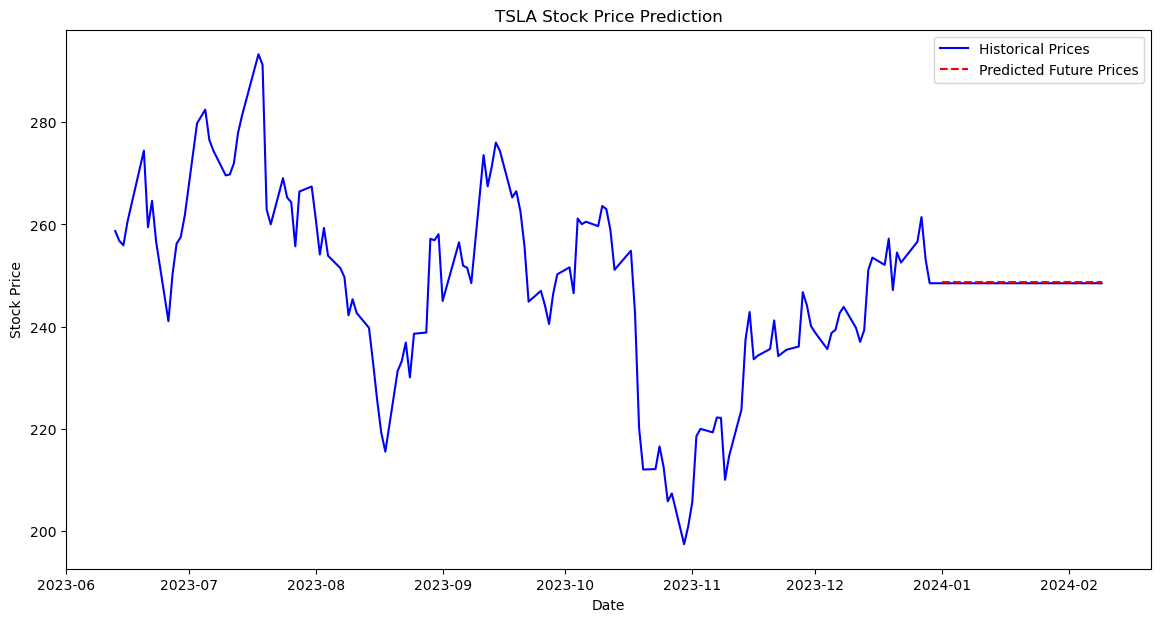

In [30]:
plt.figure(figsize=(14,7))
plt.plot(data.index, data['Close'], color='blue', label='Historical Prices')
plt.plot(data.index, data['Predicted'], color='red', linestyle='--', label='Predicted Future Prices')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [31]:
# Step 9: Save the Model

In [32]:
with open('linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)